In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.lines as mlines
plt.rcParams["figure.figsize"] = (8,8)

6 - coloque aqui o path para os dados

In [2]:
path = '../data'

1

In [3]:
def get_ficheiros(actor='',emocao='',orderby='actor',path='data'):
    actores = {i for i in os.listdir(path) if i.split('-')[-1].split('.')[0] == actor}
    emocoes = {i for i in os.listdir(path) if i.split('-')[2] == emocao}
    if (len(actores) == 0) ^ (len(emocoes) == 0):
        nome_ficheiros = list(actores.union(emocoes))
    else:
        nome_ficheiros = list(actores.intersection(emocoes))
        
    if len(nome_ficheiros) == 0:
        if orderby == 'actor':
            nome_ficheiros = sorted(os.listdir(path), key=lambda i: int(i.split('-')[-1].split('.')[0]))
        else:
            nome_ficheiros = sorted(os.listdir(path), key=lambda i: int(i.split('-')[2]))

    return nome_ficheiros

def get_maximo_frames(actor='',emocao='',path='data'):
    nome_ficheiros = get_ficheiros(actor=actor,emocao=emocao,path=path)
    nr_de_frames_maximo = 0
    i_max = 0
    for i,nome in enumerate(nome_ficheiros):
        with open(f'{path}/{nome}', 'r') as ficheiro:
            nr_de_frames = sum(1 for _ in ficheiro) - 1
        i_max,nr_de_frames_maximo = (i,nr_de_frames) if nr_de_frames_maximo < nr_de_frames else (i_max,nr_de_frames_maximo)
    return nr_de_frames_maximo,i_max

# O numero de landmarks nos é dado no enunciado, e por isso esta aqui "hardcoded";
# As cordenadas nesse caso são x e y e tambem estao "hardcoded".
def get_dados_estruturados(actor='',emocao='',dimensao='3d',orderby='actor',e_column=False,path='data'):
    nr_de_landmarks = 68 
    nr_de_coordenadas = 2 
    nome_ficheiros = get_ficheiros(actor=actor,emocao=emocao,orderby=orderby,path=path)
    nr_de_videos = len(nome_ficheiros)
    nr_de_frames_maximo,i_max = get_maximo_frames(actor=actor,emocao=emocao,path=path)
    
    if dimensao == '3d' and e_column:
        dados_estruturados = np.full((nr_de_videos, nr_de_landmarks*nr_de_coordenadas + 1, nr_de_frames_maximo),np.nan)
        for i,nome in enumerate(nome_ficheiros):
            emo = nome.split('-')[2]
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                    else:
                        frame = np.array(frame)[index]
                        frame = np.concatenate((frame,np.array([emo])),axis=0)
                        dados_estruturados[i,:,j-1] = frame
        return i_max,dados_estruturados
    
    elif dimensao == '3d':
        dados_estruturados = np.full((nr_de_videos, nr_de_landmarks*nr_de_coordenadas, nr_de_frames_maximo),np.nan)
        for i,nome in enumerate(nome_ficheiros):
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                    else:
                        frame = np.array(frame)[index].astype('float')
                        dados_estruturados[i,:,j-1] = frame
        return i_max,dados_estruturados
    else:
        dados_estruturados = []
        for i,nome in enumerate(nome_ficheiros):
            actor = nome.split('-')[-1].split('.')[0]
            emocao = nome.split('-')[2]
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    frame.extend([actor,emocao])
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                        index.extend([-2,-1])
                    else:
                        frame = np.array(frame)[index].astype('float')
                
                        dados_estruturados.append(frame)
        return np.array(dados_estruturados)

In [4]:
dados = get_dados_estruturados(dimensao='2d',orderby='emocao',path=path)
dados

array([[490.2, 488.8, 489.9, ..., 447.2,   1. ,   1. ],
       [490.2, 488.8, 489.9, ..., 446.5,   1. ,   1. ],
       [490.4, 488.8, 490.2, ..., 446.4,   1. ,   1. ],
       ...,
       [470.2, 474.4, 482.7, ..., 520.2,  24. ,   8. ],
       [466. , 470.5, 479.1, ..., 522.8,  24. ,   8. ],
       [461.1, 466.3, 475.8, ..., 526.2,  24. ,   8. ]])

2

In [5]:
def normalize_dados(dados):
    x = dados[:68]
    y = dados[68:]
    x_ref = (x[27] + x[8])/2
    x_max = 1280
    y_ref = (y[27] + y[8])/2
    y_max = 720
    x = (x-x_ref)/x_max
    y = (y-y_ref)/y_max
    return np.concatenate((x,y), axis=0)

dados_normalizados = normalize_dados(dados[:,:-2])
dados_normalizados = np.concatenate((dados_normalizados,dados[:,-2:]),1)
dados_normalizados

array([[ 4.29687500e-03,  4.06250000e-03,  2.92968750e-03, ...,
        -6.91406250e-03,  1.00000000e+00,  1.00000000e+00],
       [ 4.29687500e-03,  4.06250000e-03,  2.92968750e-03, ...,
        -7.46093750e-03,  1.00000000e+00,  1.00000000e+00],
       [ 4.45312500e-03,  4.06250000e-03,  3.16406250e-03, ...,
        -7.53906250e-03,  1.00000000e+00,  1.00000000e+00],
       ...,
       [-7.89491929e-17,  1.45833333e-03,  3.54166667e-03, ...,
         7.92361111e-02,  2.40000000e+01,  8.00000000e+00],
       [-5.83333333e-03, -3.95833333e-03, -1.45833333e-03, ...,
         8.28472222e-02,  2.40000000e+01,  8.00000000e+00],
       [-1.26388889e-02, -9.79166667e-03, -6.04166667e-03, ...,
         8.75694444e-02,  2.40000000e+01,  8.00000000e+00]])

3 - mostrei as primeiras 10 frames do video 1 do actor 1 com a emocao 1

In [6]:
def get_frames(actor='1',emocao='01',video_id=1,path='data'):
    i_max,dados_estruturados = get_dados_estruturados(actor=actor,emocao=emocao,path=path)
    
    frames = []
    for i,frame in enumerate(dados_estruturados[video_id].T):
        x = frame[:68]
        y = -frame[68:]
        if i == 0:
            xmin = min(x)
            xmax = max(x)
            ymin = min(y)
            ymax = max(y)
        else:
            xmin = min(x) if min(x) < xmin else xmin
            xmax = max(x) if max(x) > xmax else xmax
            ymin = min(y) if min(y) < ymin else ymin
            ymax = max(y) if max(y) > ymax else ymax
        frames.append(list(zip(x,y)))
    return frames,xmin,xmax,ymin,ymax

def plot_frames(actor='1',emocao='01',video_id=1,path='data'):
    frames,xmin,xmax,ymin,ymax = get_frames(actor=actor,emocao=emocao,video_id=video_id,path=path)
    frames = frames[0:10]
    fig, ax = plt.subplots()
    fig.set_facecolor('xkcd:midnight')
    ax.grid(False)
    ax.axis('off')
    cmapp = plt.get_cmap('Blues')
    for i,frame in enumerate(frames):
        for p in frame:
                x = p[0]
                y = p[1]
                ax.scatter(x, y, alpha=i/len(frames), facecolors='none', linewidth=3, edgecolors=cmapp(i/len(frames)), s=(12 * (len(frames)/(i+0.01)) ))
    plt.show()


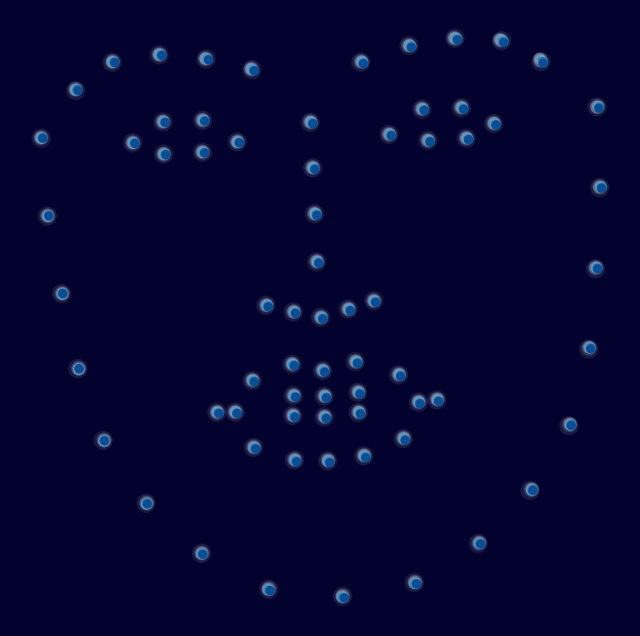

In [7]:
plot_frames(actor='1',emocao='01',video_id=1,path=path)

4

In [8]:
def groupby_numpy(array, groupby=-1):
    labels = np.unique(array[:, groupby], return_index=True)
    return labels[0],np.split(array[:,:groupby], labels[1][1:])
def plot_boxplot(grouped_data, target='distances'):
    bg_color = 'xkcd:midnight'
    other_color = 'xkcd:lightblue'
    colors = [
              'xkcd:lightblue',
              'xkcd:carolina blue',
              'xkcd:greeny blue',
              'xkcd:blue grey',
              'xkcd:dark salmon',
              'xkcd:twilight blue',
              'xkcd:royal purple',
              'xkcd:light tan',
              ]
    
    data = [i[:,0] for i in grouped_data]

    fig, ax = plt.subplots(figsize=(14,6))
    fig.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.tick_params(axis='x', colors=bg_color,pad=20,size=10)
    ax.tick_params(axis='y', colors=other_color,pad=20,size=10)
    ax.spines['bottom'].set_color(bg_color)
    ax.spines['left'].set_color(bg_color)
    ax.spines['top'].set_color(bg_color)
    ax.spines['right'].set_color(bg_color)
   
    plotted = ax.boxplot(
                            data,
                            patch_artist=True,
                            widths=0.3,
                            medianprops={"color":"white",
                                        "linewidth": 0.5},
                            boxprops={"facecolor": other_color,
                                    "edgecolor": "white",
                                    "linewidth": 0.5},
                            whiskerprops={"color": other_color,
                                        "linewidth": 1.5},
                            capprops={"color": other_color},
                            flierprops={'marker':'o',
                                        'markerfacecolor':'xkcd:dull red',
                                        'markersize':9,
                                        'linestyle':'none',
                                        'markeredgecolor':'xkcd:sky',
                                        'linewidth':1})
        
    ax.set_xticks([1,2,3,4,5,6,7,8], ['😶','😇 ','😁','😢','😡','😨','😾','😱',],fontsize=40)
    ax.set_xlabel('Emoções',fontsize=12, labelpad=20,color=other_color)
    ax.set_ylabel(f'{target}',fontsize=12,labelpad=20,color=other_color)

    for i,v in enumerate(ax.get_xticklabels()):
        v.set_color(colors[i])

    caps = plotted['caps']
    caps = [caps[n:n+2] for n in range(0, len(caps), 2)]
    boxes = plotted['boxes']
    for i,items in enumerate(zip(caps,boxes)):
        cap, box = items
        for j in range(2):
            cap[j].set(xdata=cap[j].get_xdata() + (-0.25,0.25), linewidth=2)
        box.set(facecolor=colors[i])
    
    ax.set_xlim([0,9])
    ax.set_title('Boxplot de emoções', fontsize=15, pad=100,color=other_color)
    # plt.savefig('presentation/3.2.png', dpi=300, bbox_inches = 'tight')
    plt.show()

In [10]:
x_24 = dados_normalizados[:,24]
y_24 = dados_normalizados[:,24+68]
x_46 = dados_normalizados[:,46]
y_46 = dados_normalizados[:,46+68]
distances = np.sqrt((x_24-x_46)**2 + (y_24-y_46)**2)
distances = np.concatenate((distances.reshape(-1,1),dados_normalizados[:,-1].reshape(-1,1)),axis=1)
labels,grouped_distances = groupby_numpy(distances)

In [17]:
len(grouped_distances[0])

22458

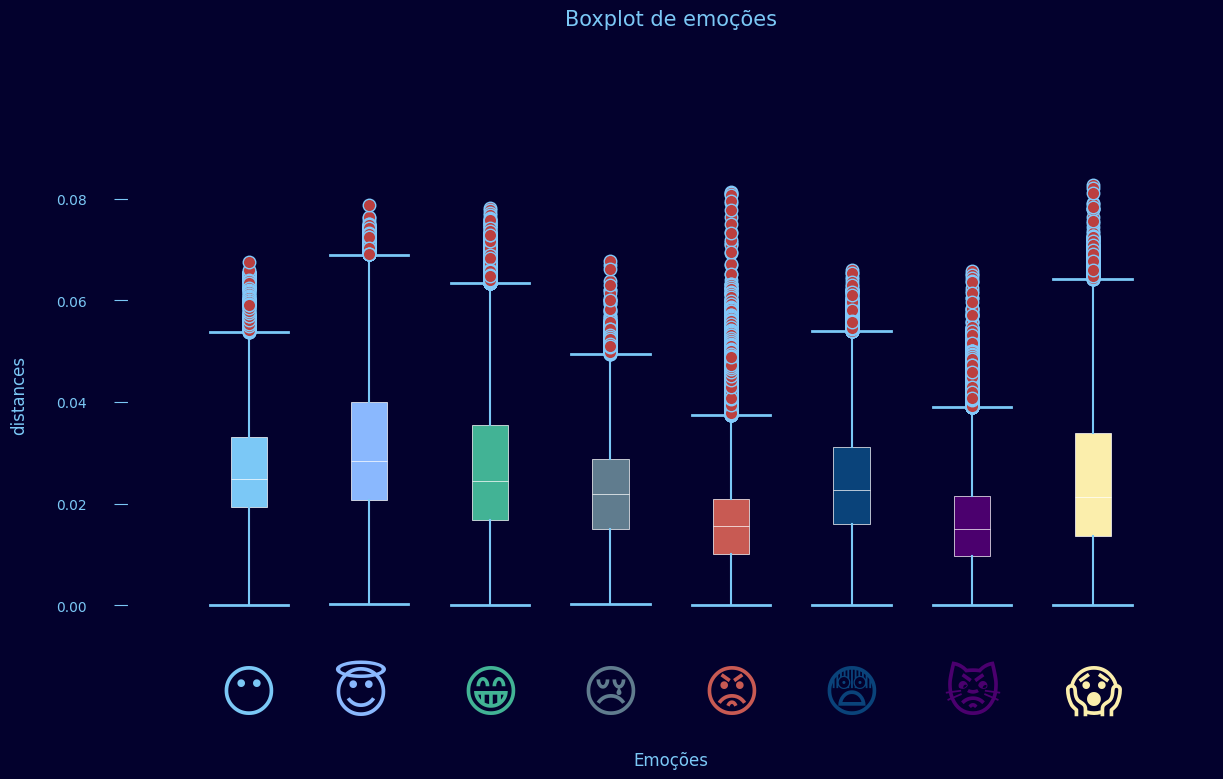

In [11]:
plot_boxplot(grouped_distances)

5

In [12]:
def get_distances_estatisticas(grouped_distances):
    
    outlier_stats = {'mean':[],'desvio padrao':[]}
    for i in grouped_distances:
        outlier_stats['mean'].append(round(i.T.mean(),2))
        outlier_stats['desvio padrao'].append(round(i.T.std(),2))
    return outlier_stats

def plot_barplot(data,label1='mean',label2='std',title='Barplot de emoções',multiple=True):

    bg_color = 'xkcd:midnight'
    other_color = 'xkcd:lightblue'
    colors = [
              'xkcd:lightblue',
              'xkcd:carolina blue',
              'xkcd:greeny blue',
              'xkcd:blue grey',
              'xkcd:dark salmon',
              'xkcd:twilight blue',
              'xkcd:royal purple',
              'xkcd:light tan',
              ]
    

    fig, ax = plt.subplots(figsize=(14,8))
    fig.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.tick_params(axis='x', colors=bg_color,pad=20,size=10)
    ax.tick_params(axis='y', colors=bg_color,pad=20,size=10)
    ax.spines['bottom'].set_color(bg_color)
    ax.spines['left'].set_color(bg_color)
    ax.spines['top'].set_color(bg_color)
    ax.spines['right'].set_color(bg_color)
   
    x = np.arange(1,9) - 0.1  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    bar_colors = ['xkcd:light maroon','xkcd:bluegreen']

    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute,color=bar_colors[multiplier])
        ax.bar_label(rects, padding=3, size=7.5, color=other_color)
        multiplier += 1
    
    ax.set_xticks([1,2,3,4,5,6,7,8], ['😶','😇 ','😁','😢','😡','😨','😾','😱',],fontsize=40)
    ax.set_xlabel('Emoções',fontsize=12, labelpad=20,color=other_color)

    for i,v in enumerate(ax.get_xticklabels()):
        v.set_color(colors[i])

    
    ax.set_xlim([0,9])
        
    ax.set_title(title, fontsize=15, pad=100,color=other_color)
    ax.margins(0.15)
    marker = mlines.Line2D([], [],
                           color=bar_colors[0], 
                           marker='o',
                           markersize=9,
                           ls='', 
                           label=f'->   {label1}')
    marker2 = mlines.Line2D([], [],
                           color=bar_colors[1], 
                           marker='o',
                           markersize=9,
                           ls='', 
                           label=f'->   {label2}')
    fig.legend(handles=[marker,marker2],bbox_to_anchor=(1.1, 0.87),
               bbox_transform=fig.transFigure,
               loc='outside upper right',
               labelcolor=other_color,
               facecolor='none',
               frameon=False)
    fig.subplots_adjust(right=0.5)
    plt.tight_layout()
    plt.show()

In [14]:
distances_stats

{'mean': [0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02],
 'desvio padrao': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02]}

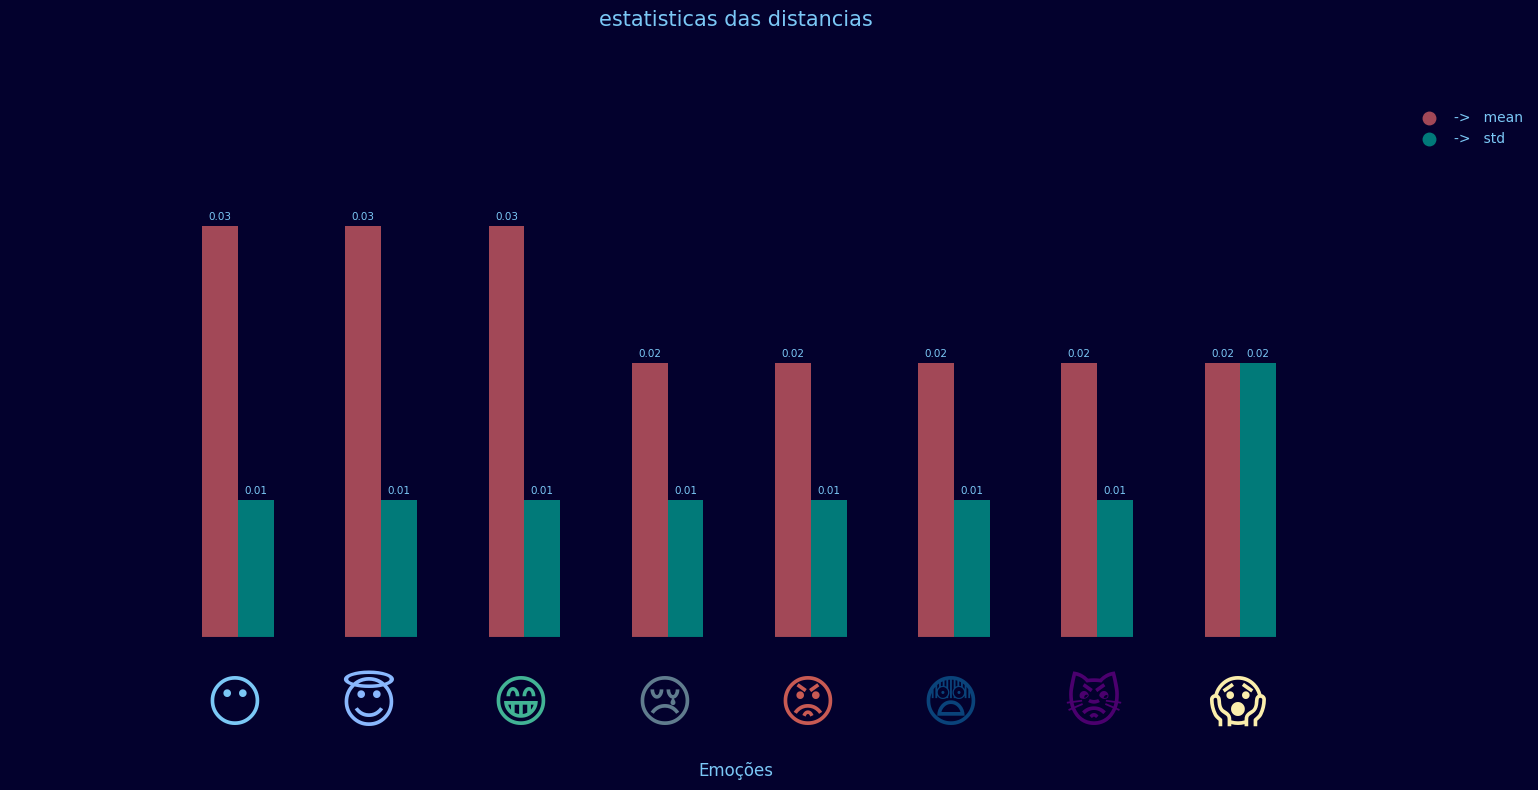

In [13]:
distances_stats = get_distances_estatisticas(grouped_distances)
plot_barplot(distances_stats,title='estatisticas das distancias')